In [1]:
using LinearAlgebra
using SparseArrays
using Random
using CairoMakie
using Statistics
using DynamicalSystemsBase
using ProgressMeter
using DataFrames
using StatsBase

In [2]:
include("EchoStateNetworks.jl")
using .EchoStateNetworks

include("ONReservoir.jl")
using .ONReservoir

In [3]:
# total_time = 300
# time_delta = 0.01
# ts_str = ["x", "y", "z"]
# init_conds = [-15.0,-15.0,10.0]
# lo_variables = [10, 8/3, 28]
# init_time_to_ignore = 10

total_time = 500
time_delta = 0.05
ts_str = ["x", "y", "z"]
init_conds = [-15.0,-15.0,10.0]
lo_variables = [10, 8/3, 28]
init_time_to_ignore = 10

10

In [4]:
function Lorenz(u, p, t)
    σ = p[1]
    β = p[2]
    ρ = p[3]

    du1 = σ*(u[2]-u[1])
    du2 = u[1]*(ρ-u[3]) - u[2]
    du3 = u[1]*u[2] - β*u[3]

    return SVector(du1, du2, du3)
end

Lorenz (generic function with 1 method)

In [5]:
lo = CoupledODEs(Lorenz, init_conds, lo_variables)
lo_tr, tvec = trajectory(lo, total_time; Δt = time_delta, Ttr = init_time_to_ignore)

(3-dimensional StateSpaceSet{Float64} with 10001 points, 10.0:0.05:510.0)

In [6]:
function SplitSet(set, ratio)
    split_point = trunc(Int, ratio*length(set))
    train_set = set[1:split_point]
    test_set = set[split_point+1:length(set)]
    
    return(train_set, test_set)
end

SplitSet (generic function with 1 method)

In [7]:
lo_train, lo_test = SplitSet(lo_tr[:,1], 0.8)

([5.126534053596909, 5.834707413699581, 6.991808357426451, 8.530218492050775, 10.224320148458034, 11.579262391541565, 11.948150768409606, 11.02325560795919, 9.2017949533067, 7.247977130696019  …  5.077681027821892, 3.0478176252011457, 1.9279701157144167, 1.437857386040465, 1.353230578626462, 1.5580404279676863, 2.033744024173971, 2.844270111435518, 4.130680100078396, 6.098330280510625], [8.922748372508533, 12.38960052200712, 15.193402641819919, 15.120150964731685, 11.69730215411192, 7.1630730712588315, 3.5237195165663295, 1.2226732082648095, -0.08865301351516021, -0.862771191380489  …  -8.078234078985824, -9.74934151620846, -11.246056374765327, -11.93797064120169, -11.372904735504541, -9.750263627364301, -7.78378266119449, -6.121317642617538, -5.0527320746766256, -4.600820630976283])

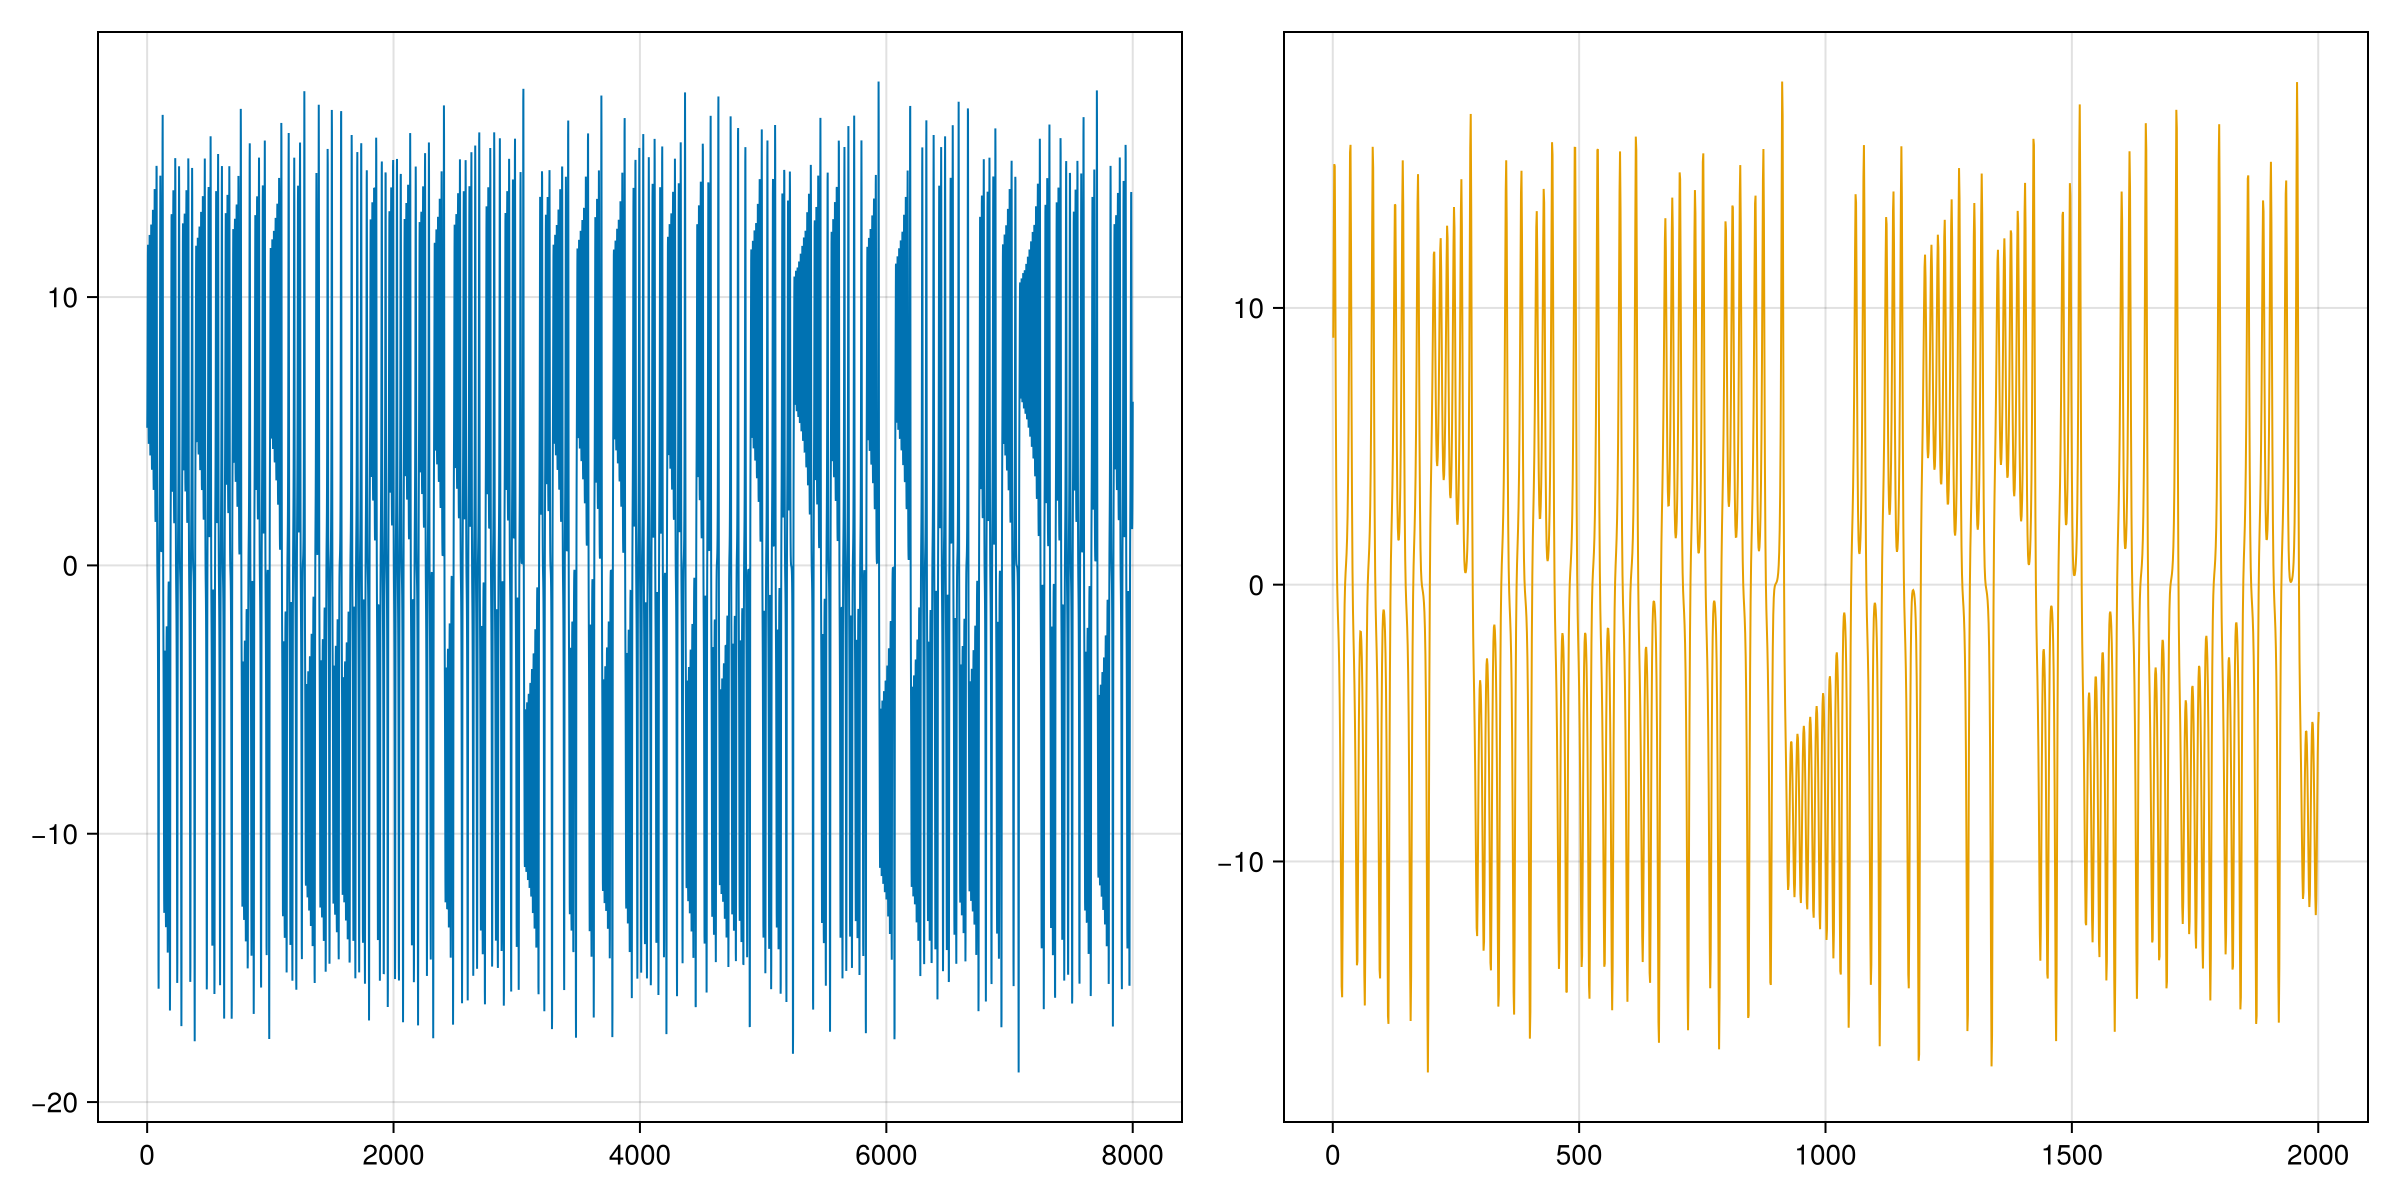

In [8]:
fig = Figure( size = (1200,600) )
lines!(Axis(fig[1,1]), lo_train; linewidth = 1.0, color = Cycled(1))
lines!(Axis(fig[1,2]), lo_test; linewidth = 1.0, color = Cycled(2))
fig

In [9]:
test_ON_part_adjacency = Dict(
    1 => [2],
    2 => [3],
    3 => [1]
)

k = 8
d = 3
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=3, part_connection=1, ON_part_adjacency=test_ON_part_adjacency)

DataFrame(ESN_params.V_rec, :auto)

24×24 DataFrame
 Row │ x1       x2       x3       x4       x5        x6       x7        x8     ⋯
     │ Float64  Float64  Float64  Float64  Float64   Float64  Float64   Float6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0    ⋯
   2 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0
   3 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0
   4 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0
   5 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.780074  0.0    ⋯
   6 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0
   7 │ 0.0      0.0      0.0      0.0      0.780074  0.0      0.0       0.0
   8 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       0.0
  ⋮  │    ⋮        ⋮        ⋮        ⋮        ⋮         ⋮        ⋮         ⋮   ⋱
  18 │ 0.0      1.17097  0.0      0.0      0.0       0.0      0.0       0.0    ⋯
  19 │ 0.0      0.0      1.17097  0.0      0.0       0.0      0.0       0.0
  20 │ 0.0      0.0      0.0      1.17097  0.0       0.0      0.0       0.0
  21 │ 0.0      0.0      0.0      0.0      1.17097   0.0      0.0       0.0
  22 │ 0.0      0.0      0.0      0.0      0.0       1.17097  0.0       0.0    ⋯
  23 │ 0.0      0.0      0.0      0.0      0.0       0.0      1.17097   0.0
  24 │ 0.0      0.0      0.0      0.0      0.0       0.0      0.0       1.1709
                                                   17 columns and 9 rows omitted

In [10]:
function RMSE(y_true, y_pred)
    return sqrt(median((y_true .- y_pred) .^ 2))
end

RMSE (generic function with 1 method)

In [26]:
function compare_preds(ON_preds, vanilla_preds, x_start, x_end)
    println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
    println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

    fig = Figure( size = (1200,600))

    ax1 = Axis(fig[1,1])
    lines!(ax1, ON_preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    ax2 = Axis(fig[1,2])
    lines!(ax2, vanilla_preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

    xlims!(x_start,x_end)
    ylims!(-25,25)

    display(fig)
end

compare_preds (generic function with 1 method)

## Single step predictions

In [11]:
function create_pred_for_params(m; k = 100, part_connection=0.5, d = k*0.05, ρ = 1.2, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 2)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=part_connection, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    preds, test_states = one_step_pred(lo_test, ESN_params, R, S = train_states[end,:], partition_symbols=part_symbols_test)

    return(preds[1:end-length(unique_partitions_test)])
end

create_pred_for_params (generic function with 1 method)

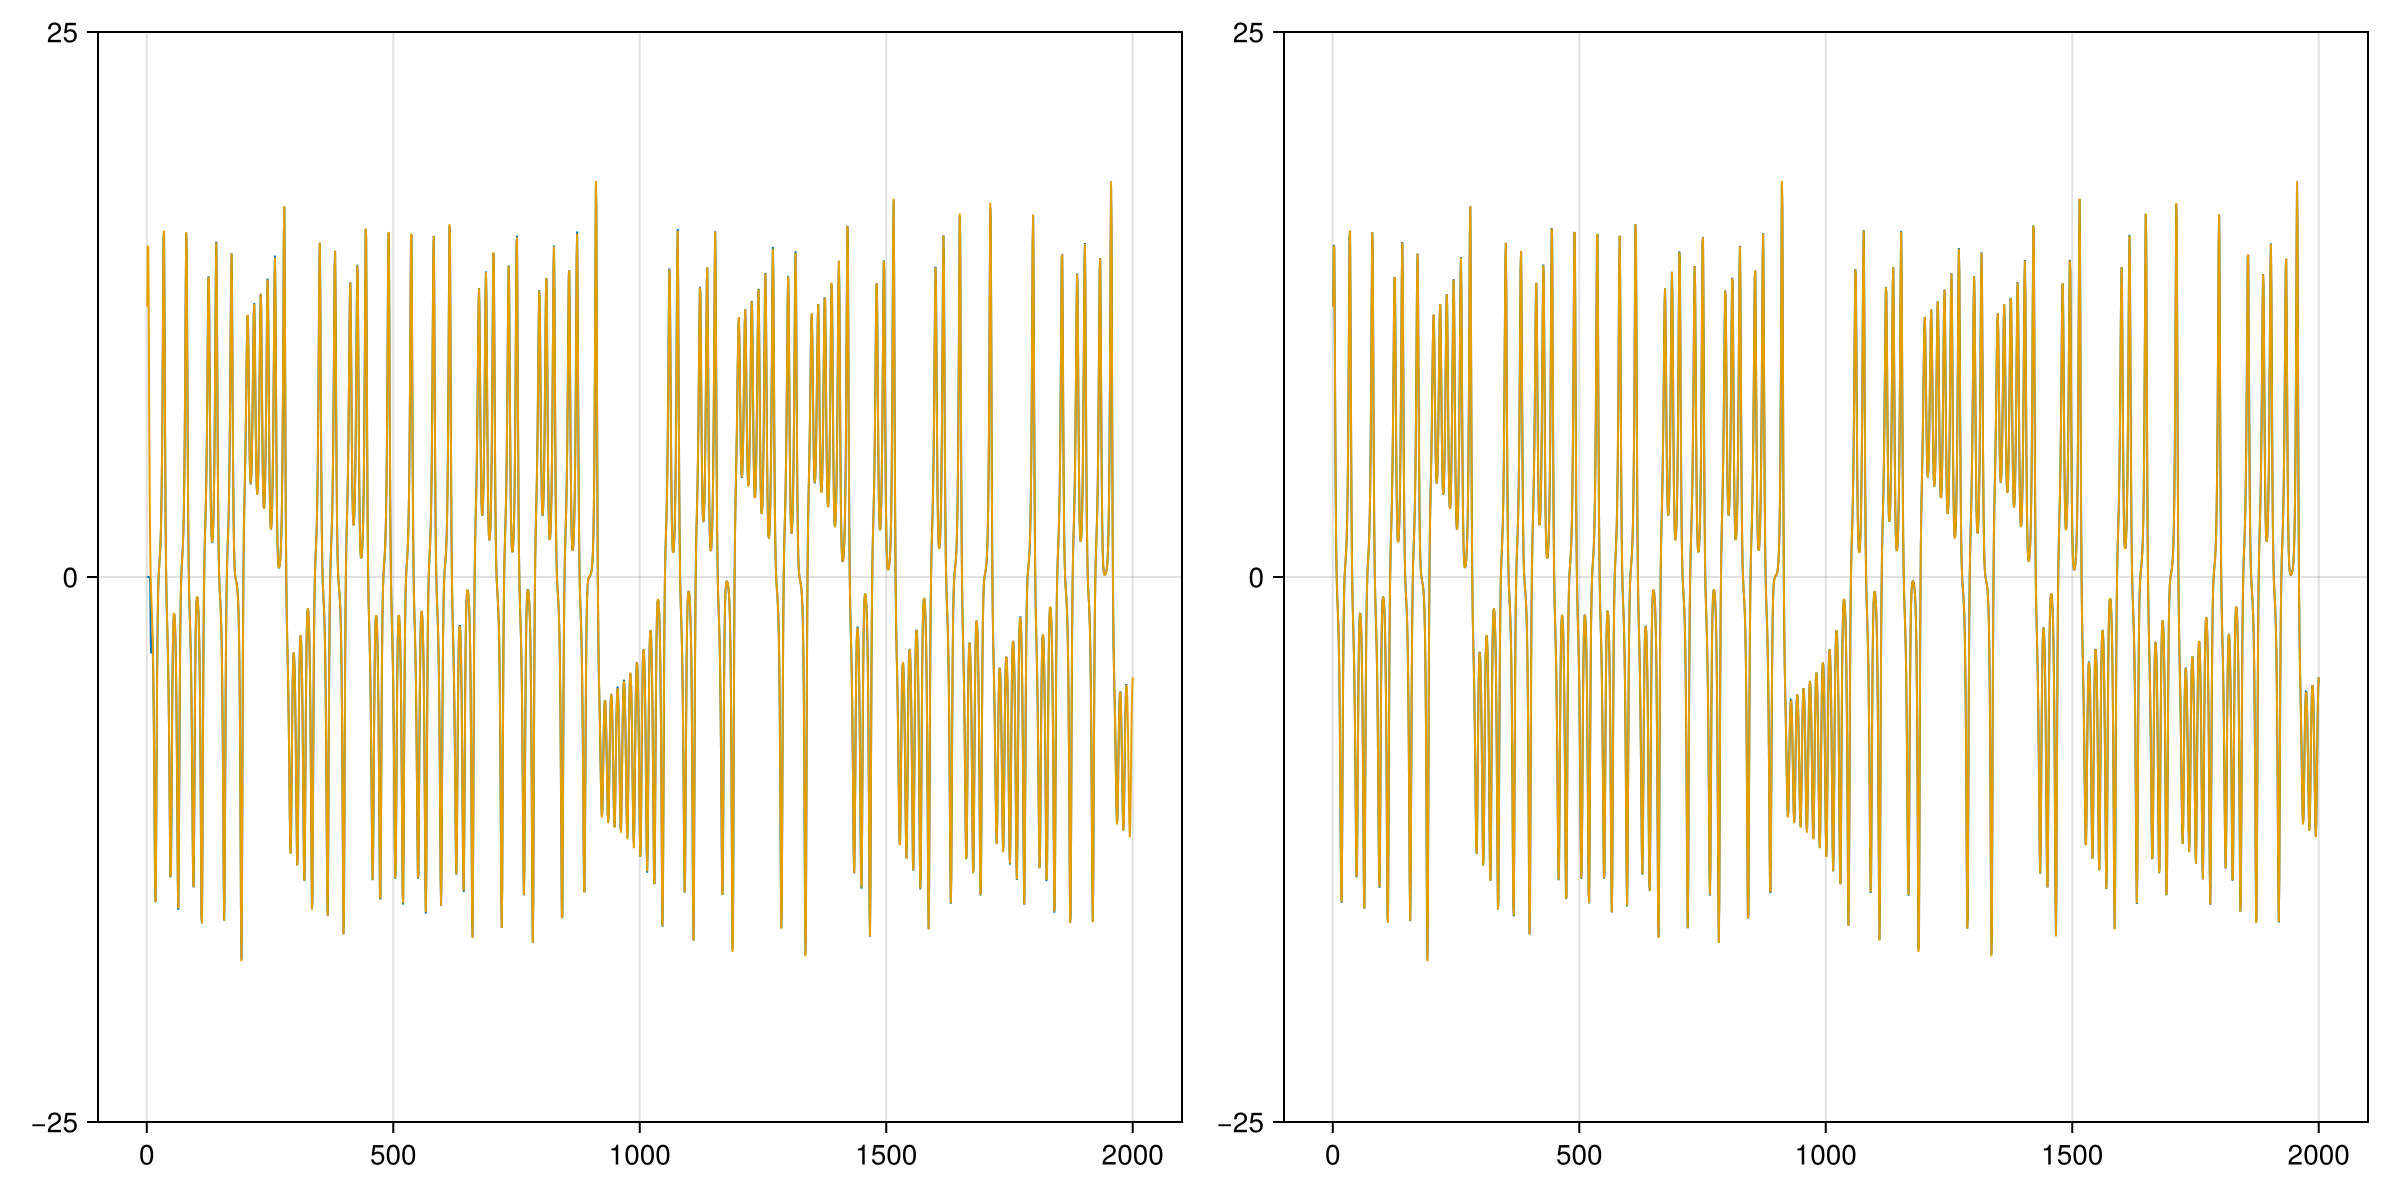

Ordinal network reservoir prediction RMSE: 0.020627951081966467
Vanilla prediction RMSE: 0.012509924517326191


CairoMakie.Screen{IMAGE}


In [27]:
ON_preds = create_pred_for_params(4; k = 100, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 100)
compare_preds(ON_preds, vanilla_preds, nothing, nothing)

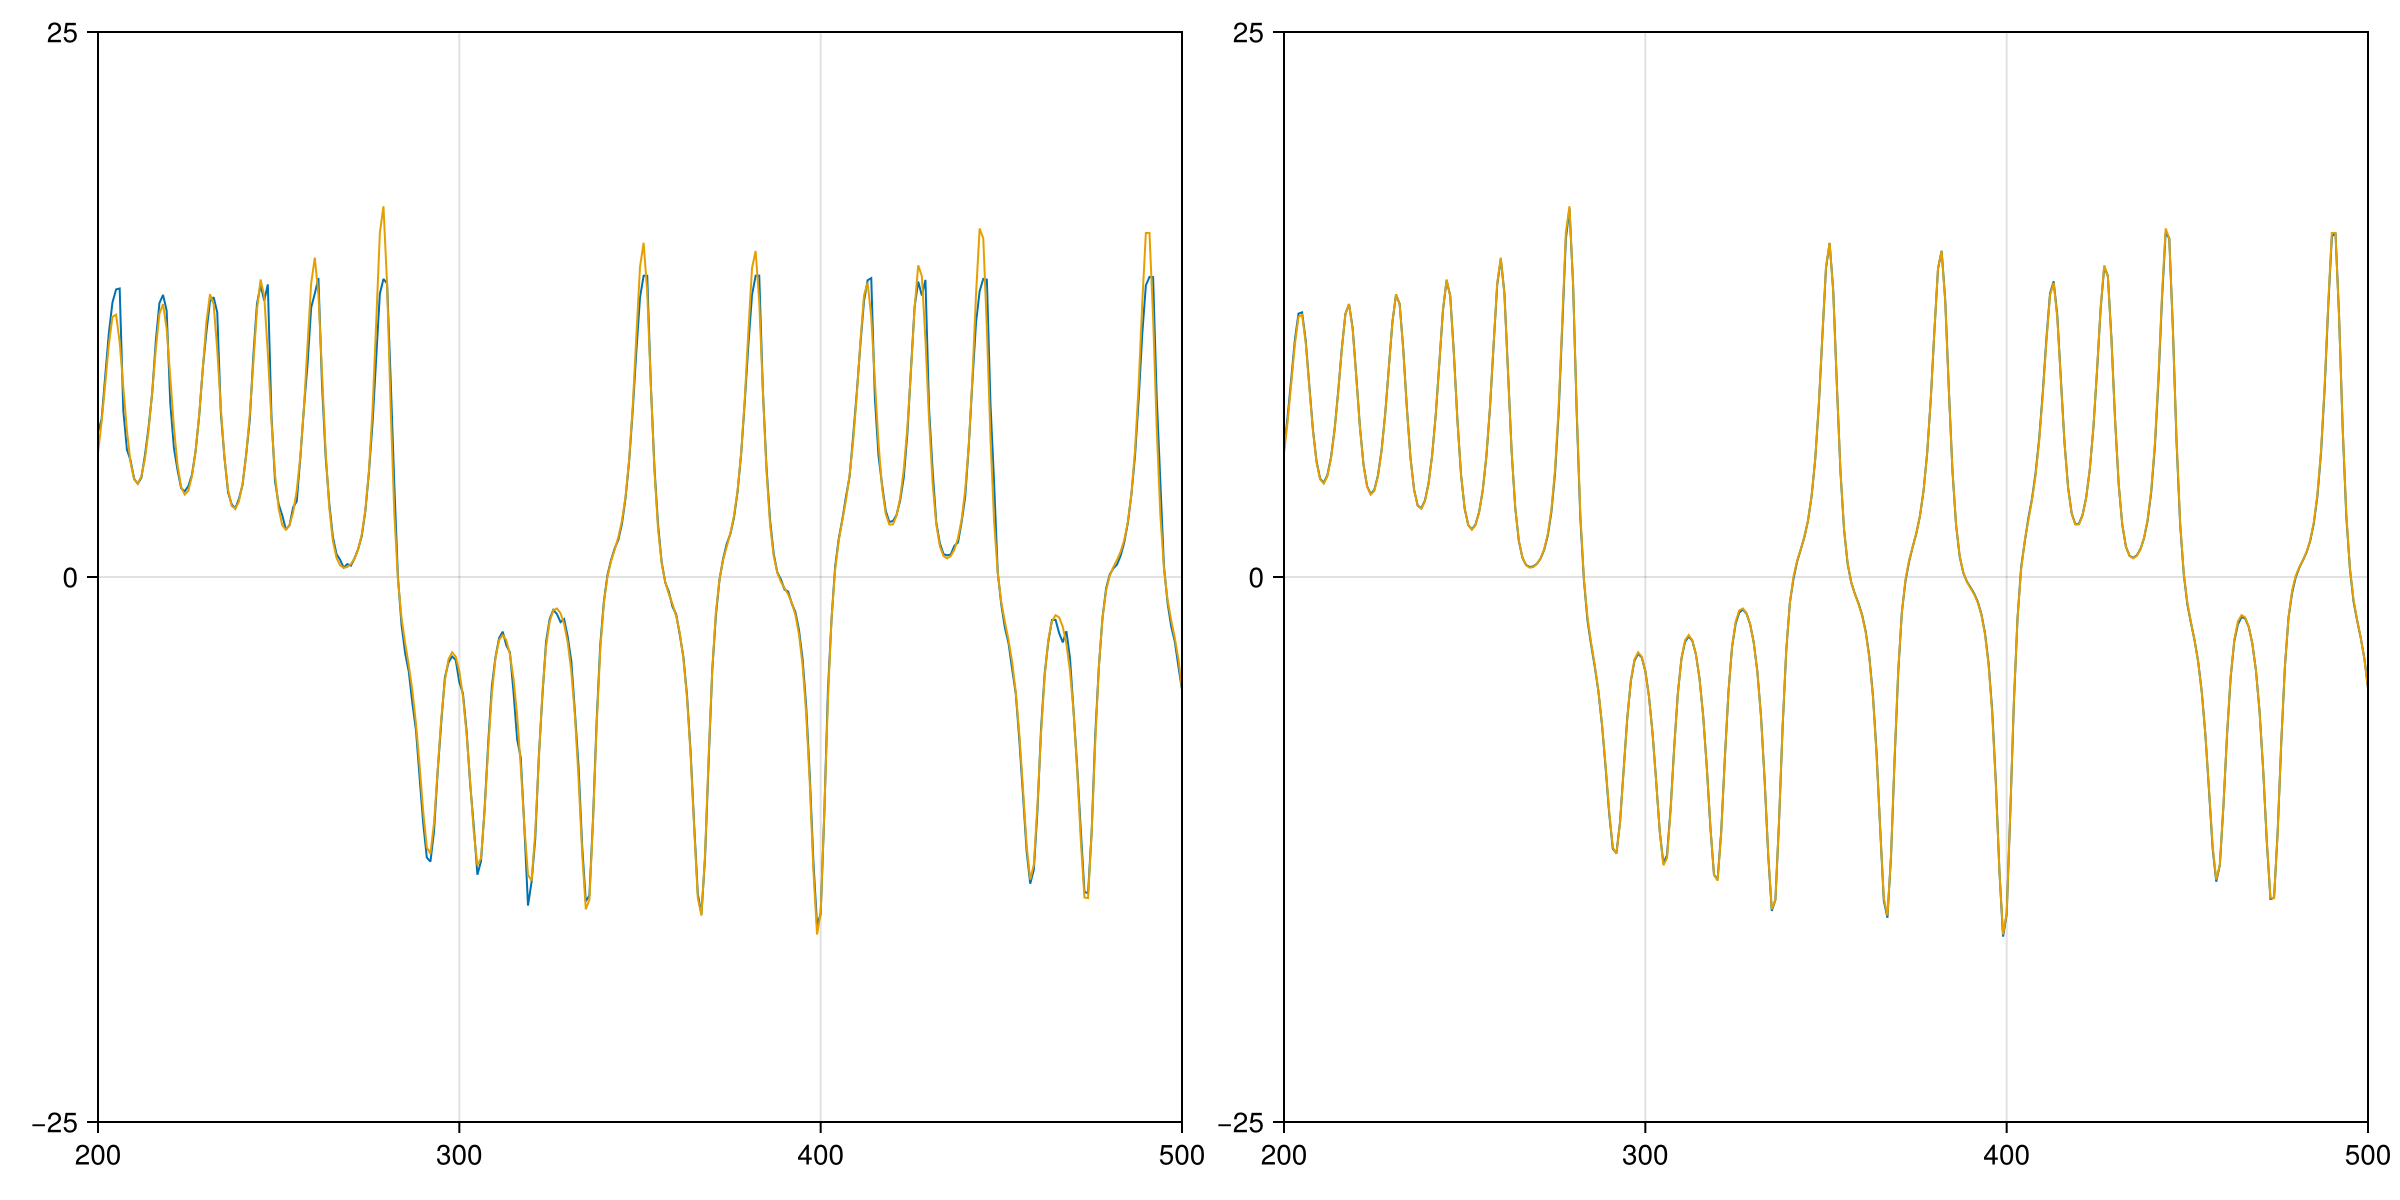

Ordinal network reservoir prediction RMSE: 0.1958370983656832
Vanilla prediction RMSE: 0.04360533023831575


CairoMakie.Screen{IMAGE}


In [30]:
ON_preds = create_pred_for_params(4; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 40)
compare_preds(ON_preds, vanilla_preds, 200, 500)

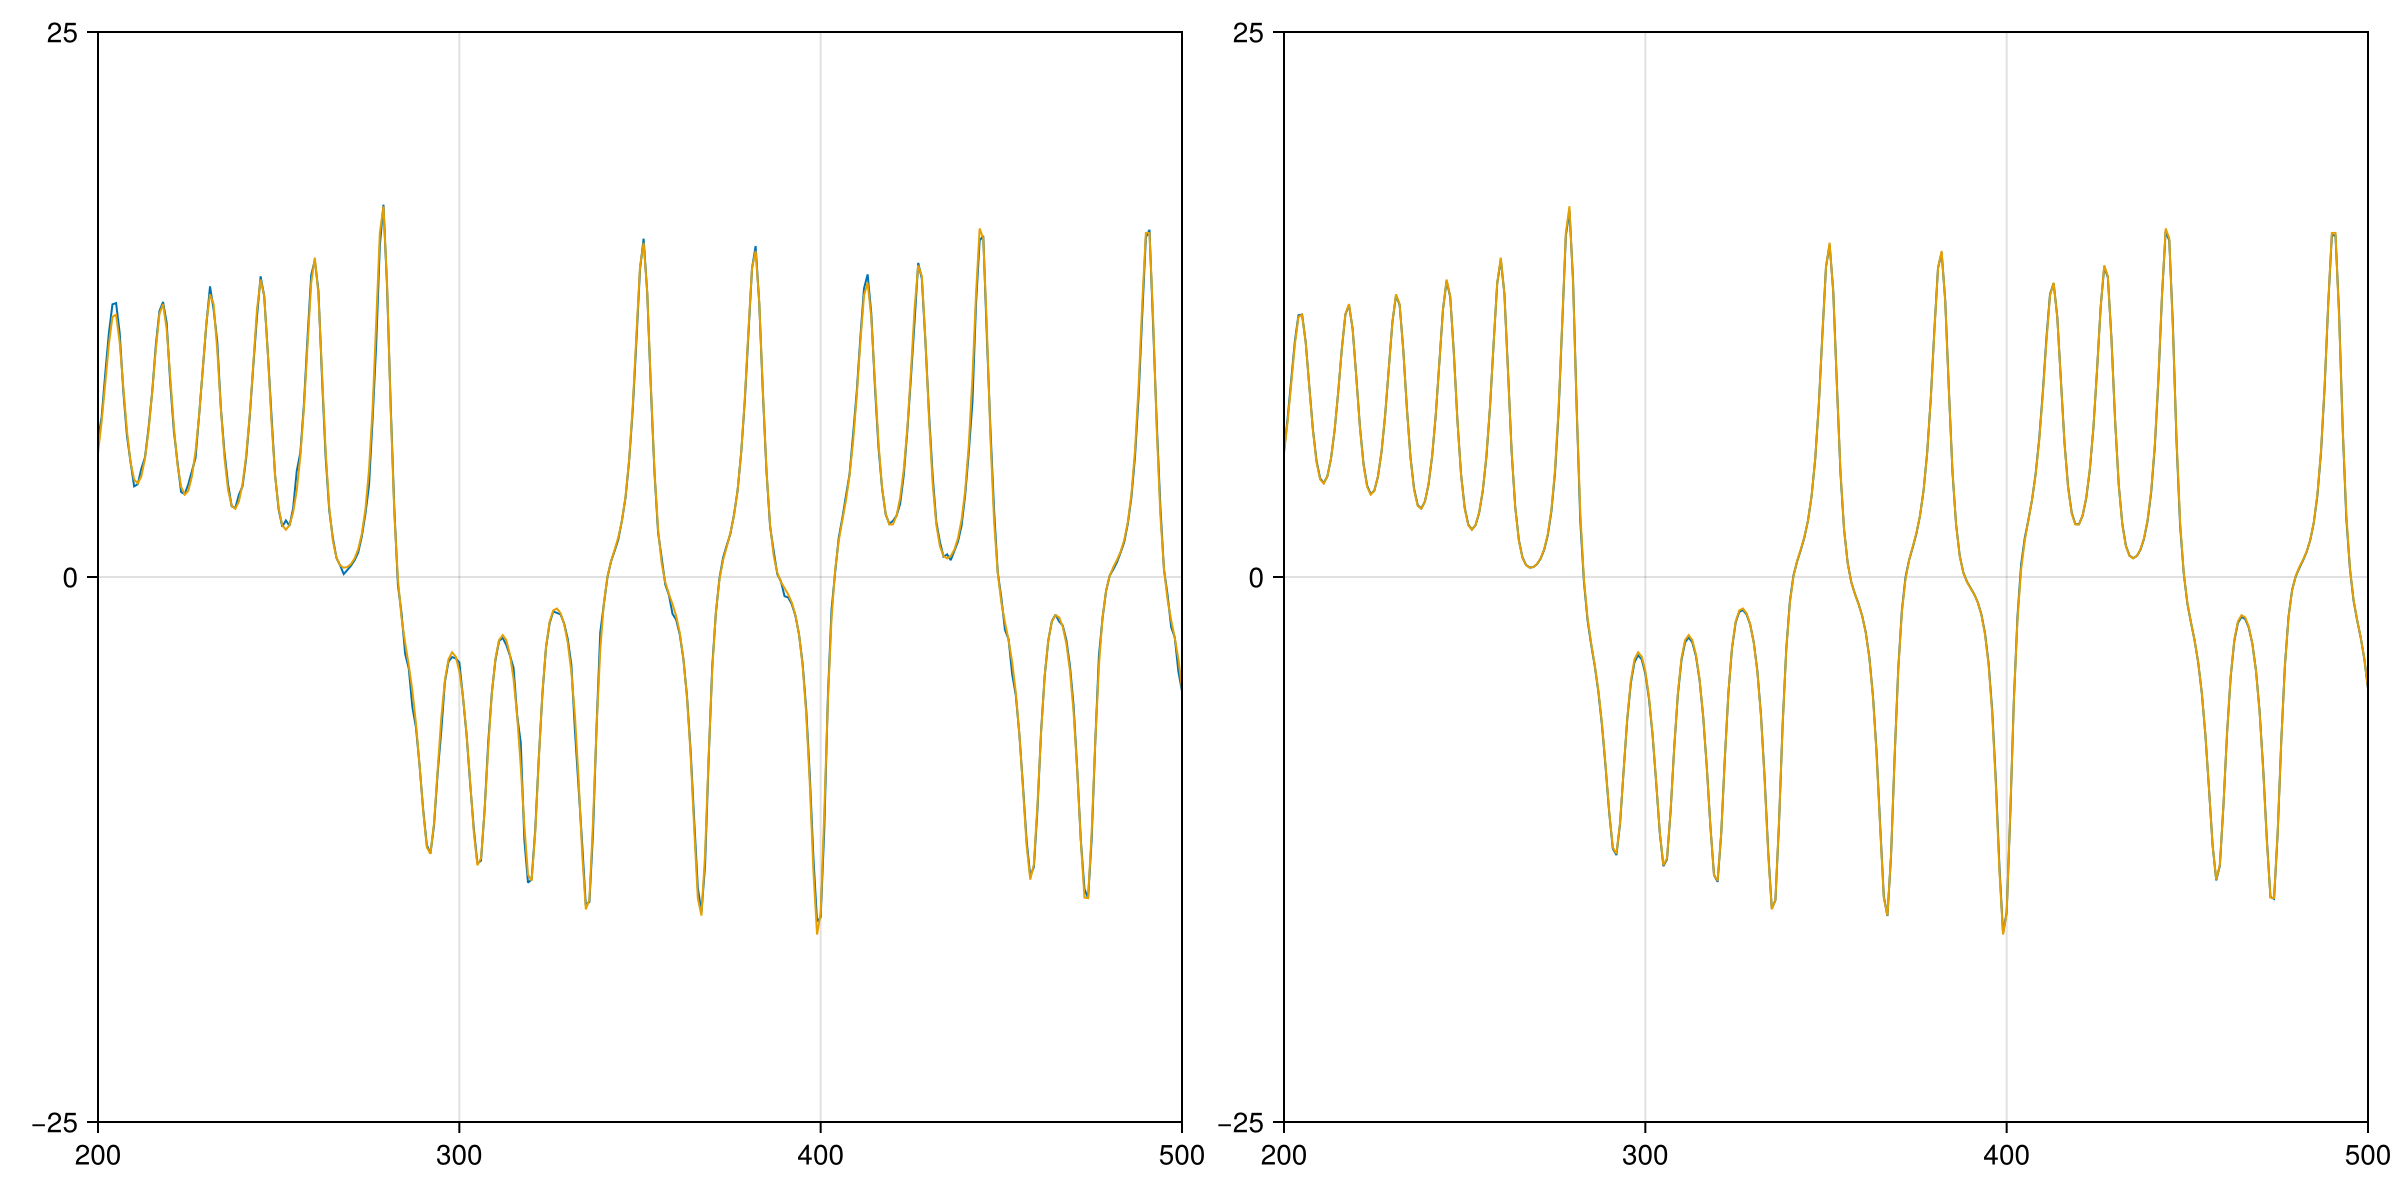

Ordinal network reservoir prediction RMSE: 0.15266529610912438
Vanilla prediction RMSE: 0.0439411571261084


CairoMakie.Screen{IMAGE}


In [13]:
ON_preds = create_pred_for_params(4; k = 10, d=2, part_connection=0.5)
vanilla_preds = create_pred_for_params(1; k = 40)

println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds, lo_test[2:length(ON_preds)+1]))
println("Vanilla prediction RMSE: ", RMSE(vanilla_preds, lo_test[2:length(vanilla_preds)+1]))

fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(200,500)
ylims!(-25,25)

display(fig)

## Freerun predictions

In [14]:
function create_pred_for_params_free_run(m; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.05, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)


    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = [lo_test[1]]
    state = train_states[end,:]
    for i in 2:length(part_symbols_test)
        # println(preds[i-1])
        # println(part_symbols_test[i])
        one_pred, one_state = one_step_pred(preds[i-1], ESN_params, R, S = state, partition_symbols=part_symbols_test[i])
        pred = one_pred[1]
        state = one_state[1,:]
        if part_symbols_test[i] == nothing
            push!(preds, lo_test[i])
            continue
        end
        push!(preds, pred)
    end
    
    return(preds)
end

create_pred_for_params_free_run (generic function with 1 method)

In [15]:
ON_preds_freerun = create_pred_for_params_free_run(4; k = 100)
vanilla_preds_freerun = create_pred_for_params_free_run(1; k = 400)
;

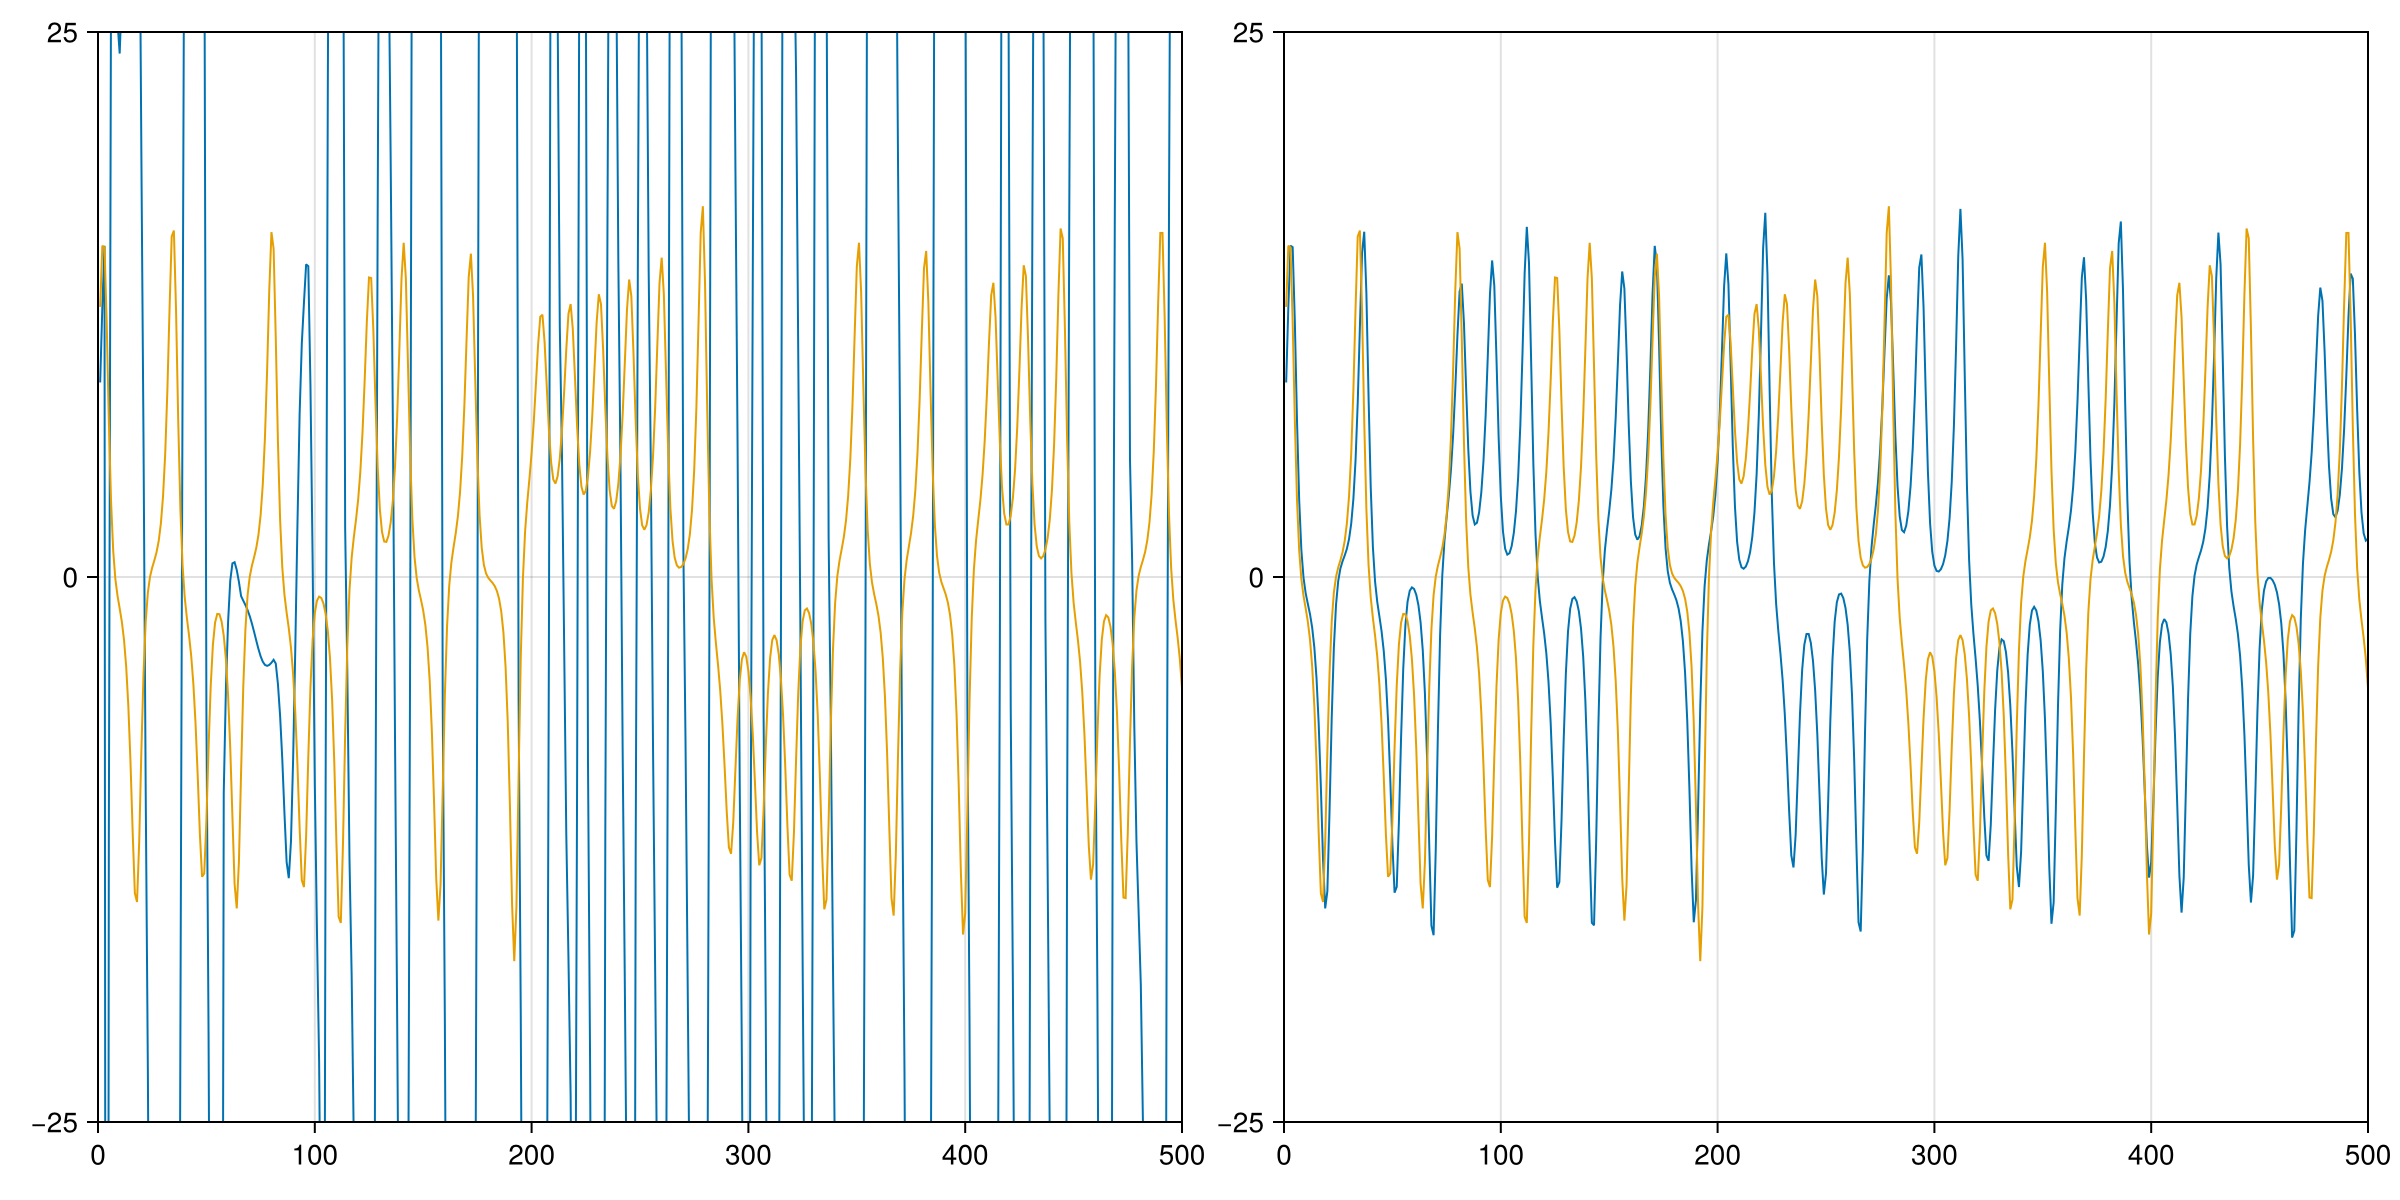

CairoMakie.Screen{IMAGE}


In [16]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds_freerun; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(0,500)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds_freerun; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))

xlims!(0,500)
ylims!(-25,25)

display(fig)

## Multi step predictions

In [17]:
function multi_step_pred(initial_value, sub_part_symbols_test, state, R, ESN_params)
    pred, state = initial_value, state
    preds = [pred]
    
    for symbol in sub_part_symbols_test
        one_pred, one_state = one_step_pred(pred, ESN_params, R, S = state, partition_symbols=symbol)
        pred = one_pred[1]
        state = one_state[1,:]
        push!(preds, pred)
    end
    
    return(preds, state)
end

function create_pred_for_params_multi_step(m, chunk_length; k = 100, d = k*0.05, ρ = 1.1, α = 1.0, η = 1/maximum(lo_train), β = 0.001, w = 1, τ = 1)
    window_size = (m-1)*τ
    
    part_symbols_train, unique_partitions_train = create_ordinal_partition(lo_train, m, w, τ)
    trans_adjacency_matrix = create_transition_matrix(part_symbols_train)
    num_partitions = length(unique_partitions_train)
    trans_adjacency_map = trans_adjacency_matrix_to_map(trans_adjacency_matrix, num_partitions)

    ESN_params = create_ESN_params(k, d, ρ, α, η, β, num_partitions=num_partitions, part_connection=0.1, ON_part_adjacency=trans_adjacency_map)

    R, train_states = train_one_step_pred(lo_train, ESN_params, partition_symbols=part_symbols_train)

    part_symbols_test, unique_partitions_test = create_ordinal_partition(lo_test, m, w, τ, unique_partitions=unique_partitions_train)
    
    preds = []
    current_state = train_states[end,:]
    current_true_value = lo_train[end]
    i = 1
    while i+chunk_length-1 < length(part_symbols_test)
        new_preds, current_state = multi_step_pred(current_true_value, part_symbols_test[i:i+chunk_length-2], current_state, R, ESN_params)
        preds = vcat(preds, new_preds)
        
        current_true_value = lo_test[i+chunk_length-1]
        
        i = i + chunk_length
    end
    
    return(preds[2:end])
end

create_pred_for_params_multi_step (generic function with 1 method)

In [18]:
ON_preds_multistep = create_pred_for_params_multi_step(3, 2; k = 400)
vanilla_preds_multistep = create_pred_for_params_multi_step(1, 2; k = 1200)
;

In [19]:
println("Ordinal network reservoir prediction RMSE: ", RMSE(ON_preds_multistep, lo_test[1:length(ON_preds_multistep)]))
println("Vanilla prediction RMSE: ", RMSE(vanilla_preds_multistep, lo_test[1:length(vanilla_preds_multistep)]))

Ordinal network reservoir prediction RMSE: 0.002081469178148332
Vanilla prediction RMSE: 0.002898057705617796


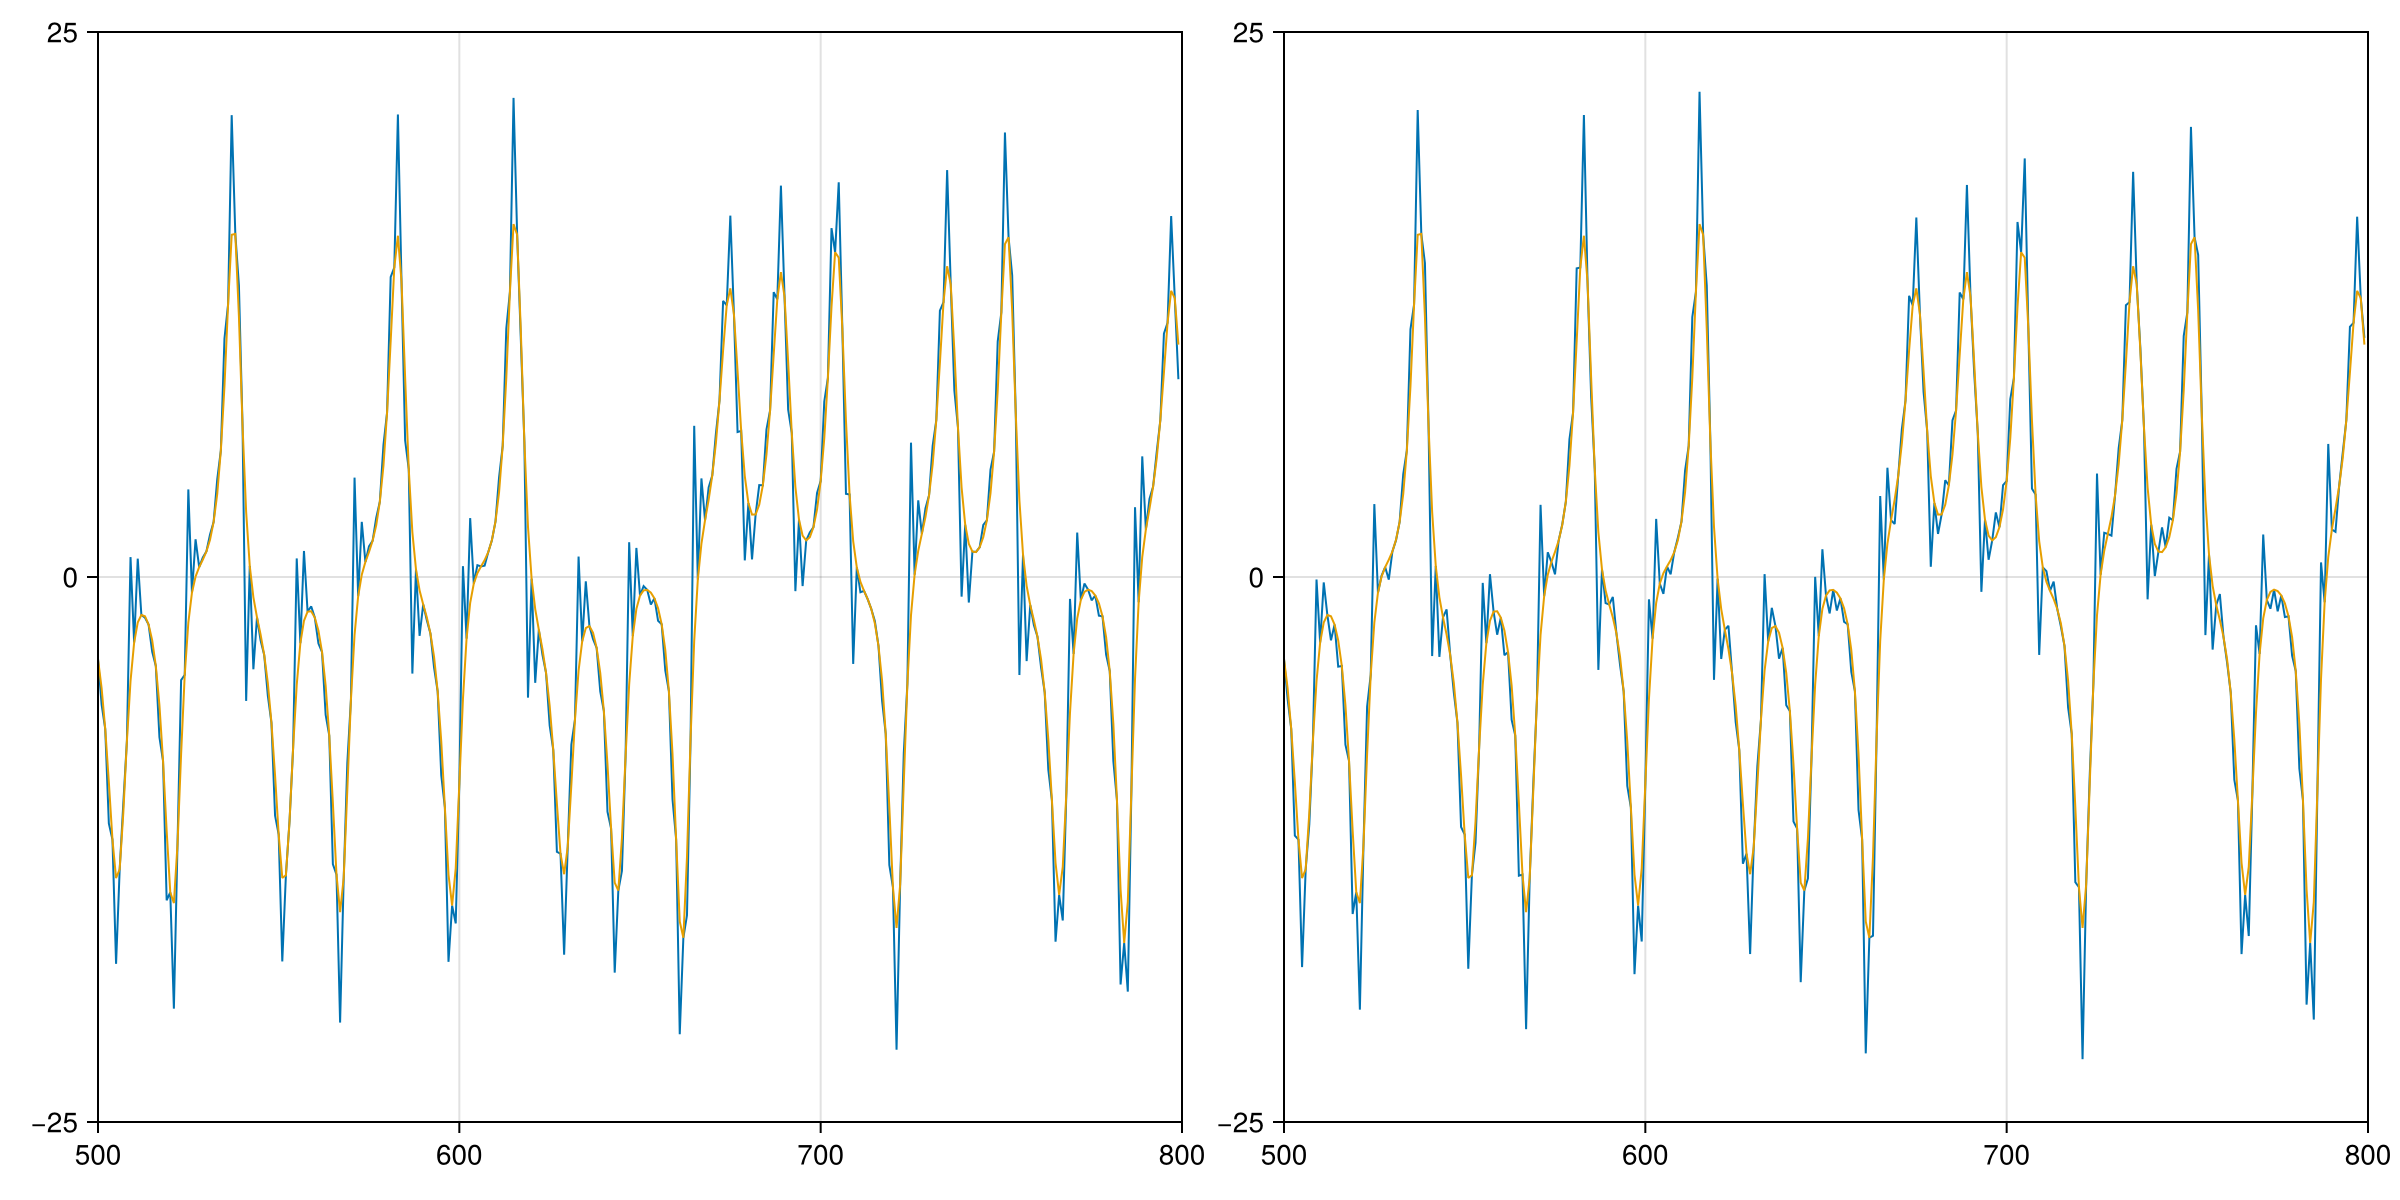

CairoMakie.Screen{IMAGE}


In [20]:
fig = Figure( size = (1200,600))

ax1 = Axis(fig[1,1])
lines!(ax1, ON_preds_multistep; linewidth = 1.0, color = Cycled(1))
lines!(ax1, lo_test; linewidth = 1.0, color = Cycled(2))

xlims!(500,800)
ylims!(-25,25)

ax2 = Axis(fig[1,2])
lines!(ax2, vanilla_preds_multistep; linewidth = 1.0, color = Cycled(1))
lines!(ax2, lo_test; linewidth = 1.0, color = Cycled(2))

xlims!(500,800)
ylims!(-25,25)

display(fig)

In [36]:
function train_one_step_pred(x, ESN_params)
    states = run_ESN(x, ESN_params)
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

In [37]:
function calculate_corr_coeffs(ESN_params, max_τ, x_length)
    u_train = randn(x_length)
    u_test = randn(x_length)
    corr_coeffs = zeros(max_τ+1)
    states_train = run_ESN(u_train, ESN_params)
    states_test = run_ESN(u_test, ESN_params)
    
    train_time = 0
    test_time = 0
    mse = 0

    for delay in 0:1:max_τ
        
        # Train an R for remembering the input 'delay' steps ago
        states_train_later = states_train[1+delay:size(states_train)[1],:]
        u_train_earlier = u_train[1:length(u_train)-delay]
        
        beginning_time = time_ns()

        R = ridge_regression(u_train_earlier, states_train_later, ESN_params.β)
        
        train_time += (time_ns()-beginning_time)/1000000
        
        states_test_later = states_test[1+delay:size(states_test)[1],:]
        u_test_earlier = u_test[1:length(u_test)-delay]
        
        beginning_time = time_ns()
        
        # Make the recollections
        test_preds = states_test_later * R
        
        test_time += (time_ns()-beginning_time)/1000000
        
        mse += mean((u_test_earlier-test_preds).^2)
        
        # Save errors (as correlation)
        corr_coeffs[delay+1] = cor(u_test_earlier, test_preds)#^2
    end
    
    println("Average train time: ", train_time/max_τ)
    println("Average test time: ", test_time/max_τ)
    println("MSE: ", mse/max_τ)
    
    return(corr_coeffs)
end

calculate_corr_coeffs (generic function with 1 method)

In [38]:
function find_max_delay(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    return(findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ))
end

find_max_delay (generic function with 1 method)

In [39]:
function plot_memory_capacity(ESN_params, max_max_τ, x_length; Ɛ=0.03)
    corr_coeffs = calculate_corr_coeffs(ESN_params, max_max_τ, x_length)
    MCs = cumsum(corr_coeffs)
    
    fig = Figure( size = (800,400), fonts = (; regular = "Tex"), fontsize = 12)
    lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
    ylims!(-0.1,1.1)
    lines!(Axis(fig[1,2], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
    ylims!(0,maximum(MCs)+1)
    
    println(string(
        "Memory capacity: ",
        findfirst(corr_coeffs .< minimum(corr_coeffs) + Ɛ)
    ))
    
    return(fig)
end

plot_memory_capacity (generic function with 1 method)

In [40]:
function one_step_errors(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)

    return(cor(lo_test[2:end], preds[1:length(preds)-1]))
end

one_step_errors (generic function with 1 method)

In [41]:
function plot_one_step_test(ESN_params)
    R, train_states = train_one_step_pred(lo_train, ESN_params)
    preds, test_states = one_step_pred(lo_test, ESN_params, R)
    
    fig = Figure( size = (1200,600))
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(0,200)
    ylims!(-25,25)
    
    ax1 = Axis(fig[2,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    xlims!(length(lo_test)-200,length(lo_test))
    ylims!(-25,25)
    display(fig)
    
    println(string("Error (correlation): ", cor(preds[1:end-1], lo_test[2:end])))
end

plot_one_step_test (generic function with 1 method)

In [42]:
k = 100
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

UndefVarError: UndefVarError: `create_ESN_params` not defined

## One-step Prediction, Correlation (error) and Memory Capacity

In [43]:
plot_one_step_test(ESN_params)
mem_cap_fig = plot_memory_capacity(ESN_params, 30, 10000)

UndefVarError: UndefVarError: `ESN_params` not defined

In [44]:
rho_test_range = 0:0.01:5.0
rho_test_errs = [one_step_errors(create_ESN_params(k, d, ρ_i, α, η, β)) for ρ_i in rho_test_range]

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [45]:
# save("memory_capacity.pdf", mem_cap_fig)

In [46]:
corr_coeffs = calculate_corr_coeffs(ESN_params, 30, 10000)
MCs = cumsum(corr_coeffs)

fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)
lines!(Axis(fig[1,1], xlabel=L"\tau", ylabel="Correlation",xlabelsize=20), corr_coeffs)
ylims!(-0.1,1.1)

# save("correlation.pdf", fig)

fig

UndefVarError: UndefVarError: `ESN_params` not defined

In [47]:
fig = Figure( size = (400,400), fonts = (; regular = "Tex"), fontsize = 16)

lines!(Axis(fig[1,1], xlabel=L"\tau_{max}", ylabel="Memory Capacity",xlabelsize=20), MCs)
ylims!(0,maximum(MCs)+1)

# save("memory_capacity.pdf", fig)

fig

UndefVarError: UndefVarError: `MCs` not defined

## Spectral radius vs error (correlation)

In [48]:
# plot(collect(rho_test_range),
#     rho_test_errs)
f = Figure()

ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Error (correlation)",
    title = "Title")
scatter!(collect(rho_test_range), rho_test_errs)

f

UndefVarError: UndefVarError: `rho_test_errs` not defined

When the spectral radius is low, the correlation of the predicted to the actual trajectory appears to be high (approximately 1). As the spectral radius increases, the correlation drops and becomes more distributed randomly between -1 and 1. The correlation begins to drop between ρ=1 and ρ=2 and appears randomly distributed above around ρ=2.5.

## Spectral radius vs memory capacity

In [49]:
# rho_test_mems = [find_max_delay(create_ESN_params(k, d, ρ_i, α, η, β), 30, 10000)
#         for ρ_i in rho_test_range]

In [50]:
# f = Figure(size = (600, 400), fontsize = 12, fonts = (; regular = "Tex", weird = "Blackchancery"))

# ax = Axis(f[1, 1], xlabel = "ρ", ylabel = "Memory Capacity",
#     title = "Memory Capacity vs. ρ", titlefont=:regular)
# scatter!(collect(rho_test_range), rho_test_mems)
# # set_theme!(font="Computer Modern")

# f

In [51]:
# save("memory capacity vs rho.pdf", f)#, pdf_version="1.4")

In [52]:
# ρ = 1.0
# k_test_range = [10,20,40,80,160]#50,100,200]#,500,1000]

# for k_i in k_test_range
#     println(k_i)
# #     
#     K_test_mem = find_max_delay(create_ESN_params(k_i, k_i*0.05, ρ, α, η, β), 30, 100000)
    
#     println(K_test_mem)
# end

As the spectral radius increases, the memory capacity generally increases up to around ρ=1.5 to ρ=2, afterwhich it decreases and plateaus around 1 to 6. After around ρ=1, the memory capacity becomes more variable, increasing from range of approximately 3-4 to a range of approximately 15.

## Freerun prediction

In [53]:
k = 50
d = k*0.05
ρ = 1.1
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)
R, train_states = train_one_step_pred(lo_train, ESN_params)


num_pred_steps = 400

current_state = train_states[end, :]
pred = [lo_train[end]]

preds = zeros(num_pred_steps)

for i in 1:num_pred_steps
    pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)

    current_state = current_state'
    preds[i] = pred[1]
end


fig = Figure( size = (1200,600) )
ax = Axis(fig[1,1])
lines!(ax, lo_train)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(lo_test)-1, lo_test)
lines!(ax, length(lo_train)+1:length(lo_train)+1+length(preds)-1, preds)
# xlims!(600,1000)
ylims!(-20,20)
fig

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [57]:
function train_one_step_pred(x, ESN_params; states=nothing)
    if states != nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[2:length(x)]
    predicted_states = states[1:size(states)[1]-1,:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function one_step_pred(x, ESN_params, R; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*R
    
    return(preds, states)
end

one_step_pred (generic function with 1 method)

# Ordinal Readout Switching

In [62]:
function train_one_step_pred_with_mask(x, ESN_params, mask; states = nothing)
    if states == nothing
        states = run_ESN(x, ESN_params)
    end
    
    target_z = x[[false; mask[1:end-1]]]
    predicted_states = states[1:size(states)[1]-1,:][mask[1:end-1],:]
    
    R = ridge_regression(target_z, predicted_states, ESN_params.β)
    
    return(R, states)
end

function train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = nothing)
    num_symbols = length(unique_partitions)
    Rs = Matrix(undef, num_symbols, ESN_params.k)

    for i in 1:num_symbols
        part_mask = [part_symbols .== i; fill(false, window_size)]
        R, train_states = train_one_step_pred_with_mask(lo_train, ESN_params, part_mask; states=states)
        Rs[i, :] = R
    end
    
    return(Rs)
end

function one_step_pred_partitioned(x, ESN_params, Rs; S = nothing)
    states = run_ESN(x, ESN_params; S = S)
    preds = states*Rs'
    
    return(preds, states)
end

one_step_pred_partitioned (generic function with 1 method)

In [63]:
function switch_prediction(y, prediction_series, unique_partitions, m, w, τ)
    part_symbols, _ = create_ordinal_partition(y, m, w, τ; unique_partitions = unique_partitions)
    switching_prediction = [prediction_series[i, part_symbols[i]] for i in 1:length(part_symbols)]
    
    return(switching_prediction)
end

switch_prediction (generic function with 1 method)

In [64]:
k = 50
d = k*0.05
ρ = 1.05
α = 1.0
η = 1/maximum(lo_train)
β = 0.01

ESN_params = create_ESN_params(k, d, ρ, α, η, β)

states = run_ESN(lo_train, ESN_params)

# Train regular ol' ESN
R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

# Create ordinal partition
m = 3
w = 1
τ = 2
window_size = (m-1)*τ
part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

# Train partition based readout
Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states=states)
# Create transition matrix and modify the partition based readout
transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [65]:
preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
# switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])

UndefVarError: UndefVarError: `states` not defined

In [66]:
start_skip = 10

println(cor(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end]))
println(cor(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)]))
println(cor(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)]))

UndefVarError: UndefVarError: `vanilla_preds` not defined

In [67]:
for preds in [vanilla_preds, switching_pred, ON_modified_switching_pred]
    println(cor(preds[1+9:end-1], lo_test[2+9:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

UndefVarError: UndefVarError: `vanilla_preds` not defined

In [68]:
function freerun_prediction(R, current_state, ESN_params; switch=false, unique_partitions=nothing, window_size=nothing, m=nothing, w=nothing, τ=nothing)
    num_pred_steps = length(lo_test)
    
    if switch
        num_pred_steps = num_pred_steps - window_size
    end
    
    pred = [lo_train[end]]
    preds = zeros(num_pred_steps)

    for i in 1:num_pred_steps
        if switch
            all_preds, current_state = one_step_pred_partitioned(pred, ESN_params, R; S=current_state)
            pred = switch_prediction(lo_test[i:i+window_size], all_preds, unique_partitions, m, w, τ)
        else
            pred, current_state = one_step_pred(pred, ESN_params, R; S=current_state)
        end

        current_state = current_state'
        preds[i] = pred[1]
    end
    
    return(preds)
end

freerun_prediction (generic function with 1 method)

In [69]:
vanilla_freerun_preds = freerun_prediction(R, train_states[end, :], ESN_params)
switching_freerun_pred = freerun_prediction(Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
ON_modified_switching_freerun_pred = freerun_prediction(transition_matrix_modified_Rs, train_states[end, :], ESN_params; switch=true, unique_partitions=unique_partitions, window_size=window_size, m=m, w=w, τ=τ)
;

UndefVarError: UndefVarError: `R` not defined

In [70]:
for preds in [vanilla_freerun_preds, switching_freerun_pred, ON_modified_switching_freerun_pred]
    println(cor(preds[1:end-1], lo_test[2:length(preds)]))
    
    fig = Figure( size = (1200,600) )
    ax1 = Axis(fig[1,1])
    lines!(ax1, preds; linewidth = 1.0, color = Cycled(1))
    lines!(ax1, lo_test[2:end]; linewidth = 1.0, color = Cycled(2))
    # xlims!(0,300)
    ylims!(-25,25)
    display(fig)
end

UndefVarError: UndefVarError: `vanilla_freerun_preds` not defined

Seems to do better with fewer nodes. Has issue with turning points, see worse prediction around each turning point.

In [71]:
function mse(y_true, y_pred)
    return mean((y_true .- y_pred) .^ 2)
end

function trial_parameters(;
        k = 50,
        d = k*0.05,
        ρ = 1.05,
        α = 1.0,
        η = 1/maximum(lo_train),
        β = 0.01,
        m = 3,
        w = 1,
        τ = 1
    )
    ESN_params = create_ESN_params(k, d, ρ, α, η, β)

    states = run_ESN(lo_train, ESN_params)

    # Train regular ol' ESN
    R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

    # Create ordinal partition
    window_size = (m-1)*τ
    part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

    # Train partition based readout
    Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = states)
    # Create transition matrix and modify the partition based readout
    transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
    switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
    ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])



    start_skip = 10

    vanilla_error = mse(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end])
    switching_error = mse(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)])
    ON_modified_switching_error = mse(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)])

    return([vanilla_error, switching_error, ON_modified_switching_error])
end

function plot_results(results, x_values; title="")
    line1 = [result[1] for result in results]
    line2 = [result[2] for result in results]
    line3 = [result[3] for result in results]

    fig = Figure(size = (1000, 600))
    ax = Axis(fig[1, 1])

    lines!(ax, x_values, line1, label = "Vanilla", color = :red)
    lines!(ax, x_values, line2, label = "Switching", color = :blue)
    lines!(ax, x_values, line3, label = "ON Modified Switching", color = :green)

    fig[1, 2] = Legend(fig, ax, title, framevisible = false)

    return(fig)
end

plot_results (generic function with 1 method)

In [72]:
reproduce = 10

plot_results(
    [mean([trial_parameters(m = m) for i in 1:reproduce]) for m in 2:6],
    2:6,
    title="MSE while varying m"
)

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [73]:
plot_results(
    [mean([trial_parameters(τ = τ) for i in 1:reproduce]) for τ in 1:2:20],
    1:2:20,
    title="MSE while varying τ"
)

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [74]:
plot_results(
    [mean([trial_parameters(k = k) for i in 1:reproduce]) for k in 20:10:100],
    20:10:100,
    title="MSE while varying k"
)

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [75]:
plot_results(
    [mean([trial_parameters(ρ = ρ) for i in 1:reproduce]) for ρ in 0.6:0.1:1.5],
    0.6:0.1:1.5,
    title="MSE while varying ρ"
)

UndefVarError: UndefVarError: `create_ESN_params` not defined

Layered ESN with different reservoir for each ordinal partition. Each reservoir has the same number of nodes and the nodes will map one to one (directed) based on whether the two partitions are connected in the ordinal transition network.

In [76]:
test_ON_part_adjacency = Dict(
    1 => [2],
    2 => [3],
    3 => [1]
)

k = 40
d = k*0.05
ρ = 2.0
α = 1.0
η = 1/maximum(lo_train)
β = 0.001

ESN_params = create_ESN_params(k, d, ρ, α, η, β, m=3, part_connection=0.5, ON_part_adjacency=test_ON_part_adjacency)

UndefVarError: UndefVarError: `create_ESN_params` not defined

In [77]:
function mse(y_true, y_pred)
    return mean((y_true .- y_pred) .^ 2)
end

function trial_parameters_reservoir(;
        k = 50,
        d = k*0.05,
        ρ = 1.05,
        α = 1.0,
        η = 1/maximum(lo_train),
        β = 0.01,
        m = 3,
        w = 1,
        τ = 1
    )
    ESN_params = create_ESN_params(k, d, ρ, α, η, β)

    states = run_ESN(lo_train, ESN_params)

    # Train regular ol' ESN
    R, train_states = train_one_step_pred(lo_train, ESN_params; states = states)

    # Create ordinal partition
    window_size = (m-1)*τ
    part_symbols, unique_partitions = create_ordinal_partition(lo_train, m, w, τ)

    # Train partition based readout
    Rs = train_one_step_pred_partitioned(part_symbols, unique_partitions, ESN_params, window_size; states = states)
    # Create transition matrix and modify the partition based readout
    transition_matrix_modified_Rs = create_transition_matrix(part_symbols)*Rs

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, Rs; S = states[end,:])
    switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    preds, test_states = one_step_pred_partitioned(lo_test, ESN_params, transition_matrix_modified_Rs; S = states[end,:])
    ON_modified_switching_pred = switch_prediction(lo_test, preds, unique_partitions, m, w, τ)

    vanilla_preds, test_states = one_step_pred(lo_test, ESN_params, R; S = states[end,:])



    start_skip = 10

    vanilla_error = mse(vanilla_preds[1+start_skip:end-1], lo_test[2+start_skip:end])
    switching_error = mse(switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(switching_pred)])
    ON_modified_switching_error = mse(ON_modified_switching_pred[1+start_skip:end-1], lo_test[2+start_skip:length(ON_modified_switching_pred)])

    return([vanilla_error, switching_error, ON_modified_switching_error])
end

function plot_results(results, x_values; title="")
    line1 = [result[1] for result in results]
    line2 = [result[2] for result in results]
    line3 = [result[3] for result in results]

    fig = Figure(size = (1000, 600))
    ax = Axis(fig[1, 1])

    lines!(ax, x_values, line1, label = "Vanilla", color = :red)
    lines!(ax, x_values, line2, label = "Switching", color = :blue)
    lines!(ax, x_values, line3, label = "ON Modified Switching", color = :green)

    fig[1, 2] = Legend(fig, ax, title, framevisible = false)

    return(fig)
end

plot_results (generic function with 1 method)

In [78]:
reproduce = 5

plot_results(
    [mean([trial_parameters_reservoir(ρ = ρ) for i in 1:reproduce]) for ρ in 0.6:0.1:1.5],
    0.6:0.1:1.5,
    title="MSE while varying ρ"
)

UndefVarError: UndefVarError: `create_ESN_params` not defined